# Lending Club Case Study Notebook

### Introduction


#### Goal
    How data can be used minimize the risk of losing money while lending to customers.

#### Context of Problem
    This company is the largest online loan marketplace, facilitating personal loans, business loans, and financing of
    medical procedures. Borrowers can easily access lower interest rate loans through a fast online interface.

#### Business Problem: 
    Like most other lending companies, lending loans to ‘risky’ applicants is the largest source of financial loss
    (called credit loss). Credit loss is the amount of money lost by the lender when the borrower refuses to pay or runs away with the money owed. In other words, borrowers who default cause the largest amount of loss to the lenders. In this case, the customers labelled as 'charged-off' are the 'defaulters'.

#### Target: 
    If one is able to identify these risky loan applicants, then such loans can be reduced thereby cutting down the amount of credit loss. Identification of such applicants using EDA is the aim of this case study.

#### Risk associated with the problem
    - If the applicant is likely to repay the loan, then not approving loan is a loss of business (rejecting loans for non - default).
    
    - If the applicant is not likely to repay the loan, then approving loan may lead to financial loss (approving loans for default). The given dataset contains information about past loans and each row represents the loan details of the applicants.

#### Datset: 
    Dataset contains loan data for all loans issued through the time period 2007 t0 2011.

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
!pip install -r requirements.txt

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Import helpers function
from helpers import load_loan_data

In [4]:
loan_data_df = load_loan_data()
loan_data_df.head()

/Users/shashank.khandelwal/Library/CloudStorage/OneDrive-Logility/pcode/LendingClubCaseStudy/helpers.py:5: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('loan.csv')


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


## Data Cleanup

As per above warning, it seems that data in column 47 is having mixed dtypes. Lets Analyse it and fix it. 

In [5]:
# Print the column name at index 47
column_name = loan_data_df.columns[47]
print(column_name)
print(loan_data_df[column_name].to_list()[:20])



next_pymnt_d
[nan, nan, nan, nan, 'Jun-16', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


So, as per above this issue is because the column contains data in string format and nan value. 
We can ignore it for now. 

### Data Cleaning steps
<ol>
    <li>
        Drop columns with all null values
    </li>
    <li>
        Drop columns where null value percentage is > 60
    </li>
    <li>Drop columns with all 0 values</li>
    <li>
        Convert term into int
    </li>
    <li>
        Remove % from columns int_rate and revol_util
    </li>
        <li>
        Removing duplicate rows from the dataframe
    </li>
        <li>
        Correcting Data Types and Deriving New Columns
    </li>
        <li>
        Removing the outliers
    <li>
        Consider only rows where loan_status != Current as ongoing loans can't be used to determine credit worthiness
    </li>
    <li>
        
    </li>
    
</ol>

#### Drop columns with all null values if any


In [6]:
# Drop columns with all null values
print('Total columns Before drop:',loan_data_df.shape)
loan_data = loan_data_df.dropna(axis=1, how='all')
print('Total columns After drop:', loan_data.shape)

Total columns Before drop: (39717, 111)
Total columns After drop: (39717, 57)


#### Drop columns where null value percentage is > 60


In [7]:
# Drop columns where null value percentage is > 60

null_perc = loan_data.isnull().mean() * 100
columns_to_drop = null_perc[null_perc > 60].index
print('Columns with more than 60% null data :', columns_to_drop.values)


Columns with more than 60% null data : ['mths_since_last_delinq' 'mths_since_last_record' 'next_pymnt_d']


In [8]:
# Removing column with 60% or more null values as it will reduce the impact on analysis
loan_data = loan_data.loc[:,loan_data.isnull().sum()/loan_data.shape[0]*100<60]
# Shape of the dataframe after removing columns
print(loan_data.shape)

(39717, 54)


#### Drop columns with all 0 values if any


In [9]:
# Drop columns with all 0 values
zero_cols = loan_data.columns[(loan_data==0).all(axis=0)]
print('Columns with all 0 values : ',zero_cols.values)
loan_data.drop(columns=zero_cols, inplace=True)
print('Total columns After drop:', loan_data.shape)


Columns with all 0 values :  ['acc_now_delinq' 'delinq_amnt']
Total columns After drop: (39717, 52)


In [10]:
# Convert term into int

loan_data.term = loan_data.term.apply(lambda x: int(x.replace(' months', '')))
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,chargeoff_within_12_mths,pub_rec_bankruptcies,tax_liens
0,1077501,1296599,5000,5000,4975.0,36,10.65%,162.87,B,B2,...,0.00,Jan-15,171.62,May-16,0.0,1,INDIVIDUAL,0.0,0.0,0.0
1,1077430,1314167,2500,2500,2500.0,60,15.27%,59.83,C,C4,...,1.11,Apr-13,119.66,Sep-13,0.0,1,INDIVIDUAL,0.0,0.0,0.0
2,1077175,1313524,2400,2400,2400.0,36,15.96%,84.33,C,C5,...,0.00,Jun-14,649.91,May-16,0.0,1,INDIVIDUAL,0.0,0.0,0.0
3,1076863,1277178,10000,10000,10000.0,36,13.49%,339.31,C,C1,...,0.00,Jan-15,357.48,Apr-16,0.0,1,INDIVIDUAL,0.0,0.0,0.0
4,1075358,1311748,3000,3000,3000.0,60,12.69%,67.79,B,B5,...,0.00,May-16,67.79,May-16,0.0,1,INDIVIDUAL,0.0,0.0,0.0


#### Remove % from columns int_rate and revol_util

In [11]:
# Remove % from columns int_rate and revol_util
print('Before removal')
loan_data.head()

Before removal


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,chargeoff_within_12_mths,pub_rec_bankruptcies,tax_liens
0,1077501,1296599,5000,5000,4975.0,36,10.65%,162.87,B,B2,...,0.00,Jan-15,171.62,May-16,0.0,1,INDIVIDUAL,0.0,0.0,0.0
1,1077430,1314167,2500,2500,2500.0,60,15.27%,59.83,C,C4,...,1.11,Apr-13,119.66,Sep-13,0.0,1,INDIVIDUAL,0.0,0.0,0.0
2,1077175,1313524,2400,2400,2400.0,36,15.96%,84.33,C,C5,...,0.00,Jun-14,649.91,May-16,0.0,1,INDIVIDUAL,0.0,0.0,0.0
3,1076863,1277178,10000,10000,10000.0,36,13.49%,339.31,C,C1,...,0.00,Jan-15,357.48,Apr-16,0.0,1,INDIVIDUAL,0.0,0.0,0.0
4,1075358,1311748,3000,3000,3000.0,60,12.69%,67.79,B,B5,...,0.00,May-16,67.79,May-16,0.0,1,INDIVIDUAL,0.0,0.0,0.0


In [12]:

loan_data['int_rate'] = loan_data['int_rate'].str.rstrip('%').astype(float)
loan_data['revol_util'] = loan_data['revol_util'].str.rstrip('%').astype(float)
print('After removal')
loan_data.head()

After removal


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,chargeoff_within_12_mths,pub_rec_bankruptcies,tax_liens
0,1077501,1296599,5000,5000,4975.0,36,10.65,162.87,B,B2,...,0.00,Jan-15,171.62,May-16,0.0,1,INDIVIDUAL,0.0,0.0,0.0
1,1077430,1314167,2500,2500,2500.0,60,15.27,59.83,C,C4,...,1.11,Apr-13,119.66,Sep-13,0.0,1,INDIVIDUAL,0.0,0.0,0.0
2,1077175,1313524,2400,2400,2400.0,36,15.96,84.33,C,C5,...,0.00,Jun-14,649.91,May-16,0.0,1,INDIVIDUAL,0.0,0.0,0.0
3,1076863,1277178,10000,10000,10000.0,36,13.49,339.31,C,C1,...,0.00,Jan-15,357.48,Apr-16,0.0,1,INDIVIDUAL,0.0,0.0,0.0
4,1075358,1311748,3000,3000,3000.0,60,12.69,67.79,B,B5,...,0.00,May-16,67.79,May-16,0.0,1,INDIVIDUAL,0.0,0.0,0.0


In [13]:
# Checking for missing values across the rows
print((loan_data.isnull().sum(axis=1)).max())

6


As the max number of missing value in row is very low compared to the count of columns(54 after removing irrelevant columns), we can move ahead with process as the impact is insignificant.

In [14]:
print(loan_data.columns)


Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'last_credit_pull_d', 'collections_12_mths_ex_med', 'policy_code',
       'application_type', 'chargeoff_within_12_mths', 'pub_rec_bankruptcies',
       'tax_liens'],
      dtype='object')


#### Removing the irrelevant columns


In [15]:
# Removing irrelevant columns which are calculated after loan is approved thus have no relevance to the analysis
## The columns removed are customer behaviour variables and are calculated after thus they cannot be used as input for the analysis
loan_data=loan_data.drop(['delinq_2yrs','earliest_cr_line','inq_last_6mths','open_acc','pub_rec','revol_bal','revol_util','total_acc','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','last_credit_pull_d','application_type'],axis=1)
# Removing desc,emp_title,desc as they have no significance to the analysis as they are random varaibles and hold infomration which might not have significance to the conclusions
loan_data=loan_data.drop(['title','emp_title','desc','url'],axis=1)
# Removing zip_code as it is a masked data and cannot be used as input for the analysis
loan_data=loan_data.drop(['zip_code'],axis=1)
# Removing member_id as it is a duplicate index column and is not required for the analysis
loan_data=loan_data.drop(['member_id'],axis=1)
# Removing funded_amnt_inv as it is a internal data and is calculated after loan approval thus cannot be used as input for the analysis
loan_data=loan_data.drop(['funded_amnt_inv'],axis=1)
# Shape of the dataframe after removing columns
print(loan_data.shape)

(39717, 24)


Removed the above columns as they are customer behavior variables and are not available at time of decision and hence not useful for analysis.

#### Checking columns for irrelevant data which has no impact to analysis(having very few unqiue values)


In [16]:
# Checking columns for irrelevant data which has no impact to analysis(having very few unqiue values)
print(loan_data.nunique().sort_values(ascending=True))

tax_liens                         1
chargeoff_within_12_mths          1
policy_code                       1
collections_12_mths_ex_med        1
initial_list_status               1
pymnt_plan                        1
term                              2
loan_status                       3
pub_rec_bankruptcies              3
verification_status               3
home_ownership                    5
grade                             7
emp_length                       11
purpose                          14
sub_grade                        35
addr_state                       50
issue_d                          55
int_rate                        371
loan_amnt                       885
funded_amnt                    1041
dti                            2868
annual_inc                     5318
installment                   15383
id                            39717
dtype: int64


As there are many columns with 1 unique value and null values, we have removed them as they are not relevant to the analysis.

In [17]:
# Removing irrelevant columns which contain 1 unique value
loan_data = loan_data.loc[:,loan_data.nunique()>1]
# Shape of the dataframe after removing columns
print(loan_data.shape)

(39717, 18)


#### Removing and fixing the null values


In [18]:
# Checking for missing values across the dataframe
print(loan_data.isnull().sum().sort_values(ascending=False))

emp_length              1075
pub_rec_bankruptcies     697
annual_inc                 0
dti                        0
addr_state                 0
purpose                    0
loan_status                0
issue_d                    0
verification_status        0
id                         0
loan_amnt                  0
sub_grade                  0
grade                      0
installment                0
int_rate                   0
term                       0
funded_amnt                0
home_ownership             0
dtype: int64


In [19]:
# Checking values in emp_length columns for feasibility of inserting null values
print(loan_data.emp_length.value_counts())

emp_length
10+ years    8879
< 1 year     4583
2 years      4388
3 years      4095
4 years      3436
5 years      3282
1 year       3240
6 years      2229
7 years      1773
8 years      1479
9 years      1258
Name: count, dtype: int64


In [20]:
# Checking values in pub_rec_bankruptcies columns for feasibility of inserting null values
print(loan_data.pub_rec_bankruptcies.value_counts())

pub_rec_bankruptcies
0.0    37339
1.0     1674
2.0        7
Name: count, dtype: int64


In [21]:
# Removing null values in emp_title and emp_length columns
loan_data = loan_data.dropna(subset=['emp_length'])
# Shape of the dataframe after removing columns
print(loan_data.shape)

(38642, 18)


In [22]:
# Inserting 0 for null values in pub_rec_bankruptcies column
loan_data.fillna({'pub_rec_bankruptcies': 0},inplace=True)

In [23]:
# Checking for missing values across the dataframe
print(loan_data.isnull().sum())

id                      0
loan_amnt               0
funded_amnt             0
term                    0
int_rate                0
installment             0
grade                   0
sub_grade               0
emp_length              0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
loan_status             0
purpose                 0
addr_state              0
dti                     0
pub_rec_bankruptcies    0
dtype: int64


#### Removing duplicate rows from the dataframe


In [24]:
# Removing duplicate rows in the dataframe
loan_data = loan_data.drop_duplicates()
# Shape of the dataframe after removing duplicate rows
print(loan_data.shape)

# No duplicate rows found in the dataframe

(38642, 18)


#### Correcting Data Types and Deriving New Columns


In [25]:
# Checking information about the dataframe
print(loan_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 38642 entries, 0 to 39716
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    38642 non-null  int64  
 1   loan_amnt             38642 non-null  int64  
 2   funded_amnt           38642 non-null  int64  
 3   term                  38642 non-null  int64  
 4   int_rate              38642 non-null  float64
 5   installment           38642 non-null  float64
 6   grade                 38642 non-null  object 
 7   sub_grade             38642 non-null  object 
 8   emp_length            38642 non-null  object 
 9   home_ownership        38642 non-null  object 
 10  annual_inc            38642 non-null  float64
 11  verification_status   38642 non-null  object 
 12  issue_d               38642 non-null  object 
 13  loan_status           38642 non-null  object 
 14  purpose               38642 non-null  object 
 15  addr_state            38

In [26]:
# Correcting data type and format for columns in the dataframe
## Derving more columns with the conversion of data type
loan_data.term = loan_data.term.apply(lambda x: int(str(x).replace(' months', '')) if isinstance(x, str) else x).astype(int)
loan_data.grade=loan_data.grade.astype('category')
loan_data.sub_grade=loan_data.sub_grade.astype('category')
loan_data.emp_length=loan_data.emp_length.apply(lambda x: x.replace('years','').replace('+','').replace('< 1','0.5').replace('year','')).astype(float)
loan_data.home_ownership=loan_data.home_ownership.astype('category')
loan_data.verification_status=loan_data.verification_status.astype('category')
loan_data.issue_d=pd.to_datetime(loan_data.issue_d,format='%b-%y')
loan_data['issue_year']=pd.to_datetime(loan_data.issue_d,format='%b-%y').dt.year
loan_data['issue_month']=pd.to_datetime(loan_data.issue_d,format='%b-%y').dt.month
loan_data.purpose=loan_data.purpose.astype('category')
loan_data.addr_state=loan_data.addr_state.astype('category')

In [27]:
# Setting decimal point limit for all data 
for x in loan_data.columns:
    if(loan_data[x].dtype=='float64'):
      loan_data[x]=loan_data[x].round(2)
      
loan_data.head()

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,pub_rec_bankruptcies,issue_year,issue_month
0,1077501,5000,5000,36,10.65,162.87,B,B2,10.0,RENT,24000.0,Verified,2011-12-01,Fully Paid,credit_card,AZ,27.65,0.0,2011,12
1,1077430,2500,2500,60,15.27,59.83,C,C4,0.5,RENT,30000.0,Source Verified,2011-12-01,Charged Off,car,GA,1.00,0.0,2011,12
2,1077175,2400,2400,36,15.96,84.33,C,C5,10.0,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,small_business,IL,8.72,0.0,2011,12
3,1076863,10000,10000,36,13.49,339.31,C,C1,10.0,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,other,CA,20.00,0.0,2011,12
4,1075358,3000,3000,60,12.69,67.79,B,B5,1.0,RENT,80000.0,Source Verified,2011-12-01,Current,other,OR,17.94,0.0,2011,12


In [28]:
# Consider only rows where loan_status != Current as ongoing loans can't be used to determine credit worthiness

loan_data = loan_data[loan_data['loan_status'] != 'Current']
loan_data['loan_status'].value_counts()

loan_status
Fully Paid     32145
Charged Off     5399
Name: count, dtype: int64

As the data has been cleaned, fixed and filtered as per requirement, we can select columns required for analysis and move ahead with the analysis.

In [29]:
# selecting columns based on domain knowledge
## Id, Loan Amount, Term of loan, Interest Rate, Grade, Sub Grade, Emp Length, Home Ownership, Verification Status, Annual Income, Loan Status,Purpose of Loan, State provided by burrower, DTI ratio, Number of public record bankruptcies and derived columns of Issue month and year
loan_data = loan_data[['id','loan_amnt','term','int_rate','grade','sub_grade','emp_length','home_ownership','verification_status','annual_inc','loan_status','purpose','addr_state','dti','pub_rec_bankruptcies','issue_year','issue_month']]
# Shape of the dataframe after removing columns
loan_data.shape

(37544, 17)

In [30]:
# Divding the column as per categorical and numerical
cat_cols = ['term','grade','sub_grade','emp_length','home_ownership','verification_status','purpose','addr_state']
cont_cols=['loan_amnt','int_rate','annual_inc','dti','pub_rec_bankruptcies','issue_year','issue_month']
id_cols=['id']
result_cols=['loan_status']

## Data Analysis After Cleanup

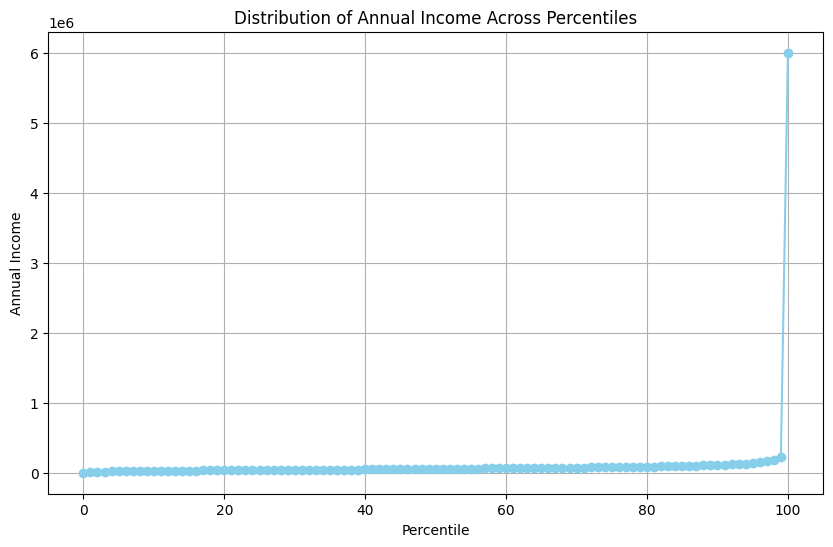

In [31]:
# Identify potential outliers
# Calculate the percentiles
percentiles = np.percentile(loan_data['annual_inc'], np.arange(0, 101, 1))

# Plotting the distribution of annual_inc in percentiles
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, 101, 1), percentiles, marker='o', color='skyblue')
plt.xlabel('Percentile')
plt.ylabel('Annual Income')
plt.title('Distribution of Annual Income Across Percentiles')
plt.grid(True)
plt.show()

Outlier seems to be after 98th percentile

NameError: name 'percentile_99' is not defined

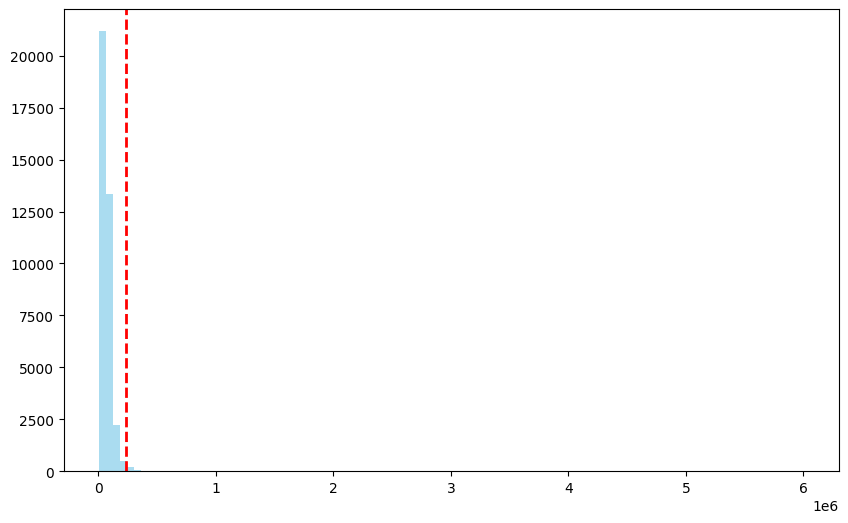

In [32]:
# Calculate the 98th percentile
percentile_98 = loan_data['annual_inc'].quantile(0.99)

# Plotting the distribution of annual_inc
plt.figure(figsize=(10, 6))
plt.hist(loan_data['annual_inc'], bins=100, color='skyblue', alpha=0.7)
plt.axvline(percentile_98, color='red', linestyle='dashed', linewidth=2)
plt.text(percentile_99, plt.ylim()[1]*0.9, f'98th percentile: {percentile_99:.2f}', color='red')
plt.xlabel('Annual Income')
plt.ylabel('Frequency')
plt.title('Distribution of Annual Income with 98th Percentile Marked')
plt.show()

Remove outliers beyond the 98th percentile:

In [ ]:
# Calculate the 99th percentile
percentile_98 = loan_data['annual_inc'].quantile(0.98)

# Remove outliers beyond the 99th percentile
loan_data = loan_data[loan_data['annual_inc'] <= percentile_98]

# Plotting the distribution of annual_inc after removing outliers
plt.figure(figsize=(10, 6))
plt.hist(loan_data['annual_inc'], bins=100, color='skyblue', alpha=0.7)
plt.xlabel('Annual Income')
plt.ylabel('Frequency')
plt.title('Distribution of Annual Income After Removing Outliers Beyond 98th Percentile')
plt.show()

In [ ]:
# Calculate the percentiles
percentiles = np.percentile(loan_data['annual_inc'], np.arange(0, 101, 1))

# Plotting the distribution of annual_inc in percentiles
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, 101, 1), percentiles, marker='o', color='skyblue')
plt.xlabel('Percentile')
plt.ylabel('Annual Income')
plt.title('Distribution of Annual Income Across Percentiles after removing outlier')
plt.grid(True)
plt.show()

## Univariate Analysis


In [ ]:
# Loan status 
print(loan_data.loan_status.value_counts()*100/loan_data.loan_status.count())
# 0=Fully Paid, 1=Charged Off
plt.figure(figsize=(10,5))
ax=sns.countplot(loan_data.loan_status)
ax.annotate('Fully Paid',xy=(0.25,0.3),xycoords='axes fraction',horizontalalignment='center',verticalalignment='center',fontsize=12)
ax.annotate('Charged Off',xy=(0.75,0.1),xycoords='axes fraction',horizontalalignment='center',verticalalignment='center',fontsize=12)
ax.set_title('Loan Status')
ax.set_xlabel('Loan Status')
ax.set_ylabel('Count')
plt.show()

##### Inference: Defaulted loan are low in numbers compared to Fully Paid.



In [ ]:
# Term of loan 
term_counts = loan_data.term.value_counts(normalize=True) * 100

# Plotting
plt.figure(figsize=(8, 6))
term_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Loan Terms')
plt.xlabel('Loan Term (months)')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.show()

Inference: More than half of the loan taken has term of 36 months compared to 60 months.



In [ ]:
# Interest Rate Distribution (`int_rate`)
int_rate_stats = loan_data['int_rate'].describe()
print("\nInterest Rate Statistics:")
print(int_rate_stats)

plt.figure(figsize=(8, 6))
sns.histplot(loan_data['int_rate'], bins=30, kde=True)
plt.title('Distribution of Interest Rate')
plt.show()

Inference: The interest rate is more crowded around 5-10 and 10-15 with a drop near 10.



In [ ]:
# Distribution of Greade
plt.figure(figsize=(10,5))
sns.countplot(loan_data.grade)
plt.xlabel('Grade')
plt.ylabel('Density')
plt.title('Distribution of Grade')
plt.show()

Inference: A large amount of loans are with grade 'A' and 'B' commpared to rest showing most loans are high grade loans.

In [ ]:
# Distribution of Annual Income (`annual_inc`)
annual_inc_stats = loan_data['annual_inc'].describe()
print("\nAnnual Income Statistics:")
print(annual_inc_stats)

plt.figure(figsize=(8, 6))
sns.histplot(loan_data['annual_inc'], bins=50, kde=True)
plt.title('Distribution of Annual Income')
plt.show()

Inference: Annual Income shows left skewed normal distribution thus we can say that the majority of burrowers have very low annual income compared to rest.

In [ ]:
# Distribution of Debt-to-Income Ratio (`dti`)

dti_stats = loan_data['dti'].describe()
print("\nDebt-to-Income Ratio Statistics:")
print(dti_stats)

plt.figure(figsize=(8, 6))
sns.histplot(loan_data['dti'], bins=30, kde=True)
plt.title('Distribution of Debt-to-Income Ratio (DTI)')
plt.show()

Inference: Majority of the borrowers have very large debt compared to the income registerd, concentrated in the 10-15 DTI ratio.

In [ ]:
# Purpose of the Loan (`purpose`)
purpose_counts = loan_data['purpose'].value_counts()
print("\nLoan Purpose Counts:")
print(purpose_counts)

plt.figure(figsize=(12, 8))
sns.countplot(y='purpose', data=loan_data, hue='loan_status', order=loan_data['purpose'].value_counts().index)
plt.title('Loan Purpose Distribution by Loan Status')
plt.show()

Inference: A large percentage of loans are taken for debt consolidation followed by credit card.



In [ ]:
# Distribution of addr_state
plt.figure(figsize=(15, 5))
sns.countplot(x='addr_state', hue='loan_status', data=loan_data)
plt.xlabel('State')
plt.ylabel('Count')
plt.title('Distribution of Loan Status by State')
plt.xticks(rotation=45)  # Rotate x labels if there are many states
plt.show()

Inference: Majority of the borrowers are from the large urban cities like california, new york, texas, florida etc.



In [ ]:
# Distribution of pub_rec_bankruptcies
# Count the occurrences of each unique value in pub_rec_bankruptcies
pub_rec_bankruptcies_counts = loan_data['pub_rec_bankruptcies'].value_counts()

# Plotting without seaborn
plt.figure(figsize=(10, 5))
plt.bar(pub_rec_bankruptcies_counts.index, pub_rec_bankruptcies_counts.values, color='skyblue')
plt.xlabel('Public Record Bankruptcies')
plt.ylabel('Count')
plt.title('Distribution of Public Record Bankruptcies', fontsize=12)
plt.show()

Inference: Majority of the borrowers have no record of Public Recorded Bankruptcy.



In [ ]:
# Distribution of issue_month

# Count the occurrences of each unique value in issue_month grouped by loan_status
issue_month_counts = loan_data.groupby(['issue_month', 'loan_status']).size().unstack(fill_value=0)

# Plotting without seaborn
plt.figure(figsize=(10, 5))
issue_month_counts.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'], ax=plt.gca())
plt.xlabel('Issue Month')
plt.ylabel('Count')
plt.title('Distribution of Loan Issue Month by Loan Status', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Loan Status')
plt.show()

Inference: Majority of the loans are given in last quarter of the year.



In [ ]:
# Revolving Credit Utilization (`revol_util`)
revol_util_stats = loan_data['revol_util'].describe()
print("\nRevolving Credit Utilization Statistics:")
print(revol_util_stats)

plt.figure(figsize=(8, 6))
sns.histplot(loan_data['revol_util'], bins=30, kde=True)
plt.title('Distribution of Revolving Credit Utilization')
plt.show()

## Bivariate Analysis

In [ ]:
# Annual Income (log-transformed) vs Loan Status
loan_data['annual_inc_log'] = np.log1p(loan_data['annual_inc'])
annual_inc_log_stats = loan_data['annual_inc_log'].describe()
print("\nLog-Transformed Annual Income Statistics:")
print(annual_inc_log_stats)

plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='annual_inc_log', data=loan_data)
plt.title('Log-Transformed Annual Income by Loan Status')
plt.show()

Inference: The mean and 25% percentile are same for both but we see larger 75% percentile in the defaulted loan which indicate large amount of loan has higher chance of defaulting.

In [ ]:
# Interest Rate vs Loan Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='int_rate', data=loan_data)
plt.title('Interest Rate by Loan Status')
plt.show()

In [ ]:
# Home Ownership Distribution by Loan Status (`home_ownership`)
home_ownership_counts = loan_data['home_ownership'].value_counts()
print("\nHome Ownership Counts:")
print(home_ownership_counts)

plt.figure(figsize=(8, 6))
sns.countplot(x='home_ownership', data=loan_data, hue='loan_status')
plt.title('Home Ownership Distribution by Loan Status')
plt.show()

Inference: Majority of borrowsers don't posses property and are on mortage or rent.



In [ ]:
# Employment Length Distribution by Loan Status (`emp_length`)
# Count the occurrences of each employment length
emp_length_counts = loan_data['emp_length'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(emp_length_counts.index, emp_length_counts.values, color='skyblue')
plt.xlabel('Employment Length')
plt.ylabel('Count')
plt.title('Distribution of Employment Length', fontsize=12)
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()

Inference: Majority of borrowsers have working experience greater than 10 years.



In [ ]:
# DTI vs Loan Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='dti', data=loan_data)
plt.title('Debt-to-Income Ratio by Loan Status')
plt.show()

In [ ]:
# Verification Status by Loan Status (`verification_status`)
verification_status_counts = loan_data['verification_status'].value_counts()
print("\nVerification Status Counts:")
print(verification_status_counts)

plt.figure(figsize=(8, 6))
sns.countplot(x='verification_status', data=loan_data, hue='loan_status')
plt.title('Verification Status by Loan Status')
plt.show()

In [ ]:
# Calculate the counts of each verification status
# Calculate total loans
total_loans = len(loan_data)

# Calculate the counts and percentages for verification status
verification_status_counts = loan_data['verification_status'].value_counts()
verified_count = verification_status_counts['Verified'] + verification_status_counts['Source Verified']
not_verified_count = verification_status_counts['Not Verified']

verified_percentage = (verified_count / total_loans) * 100
not_verified_percentage = (not_verified_count / total_loans) * 100

# Calculate charged-off loans within each group
charged_off_verified = loan_data[(loan_data['loan_status'] == 'Charged Off') & 
                                 (loan_data['verification_status'].isin(['Verified', 'Source Verified']))].shape[0]
charged_off_not_verified = loan_data[(loan_data['loan_status'] == 'Charged Off') & 
                                     (loan_data['verification_status'] == 'Not Verified')].shape[0]

charged_off_verified_percentage = (charged_off_verified / verified_count) * 100
charged_off_not_verified_percentage = (charged_off_not_verified / not_verified_count) * 100

# Print the results
print(f"Total Loans: {total_loans}")
print(f"Verified Loans: {verified_count} ({verified_percentage:.2f}%)")
print(f"Not Verified Loans: {not_verified_count} ({not_verified_percentage:.2f}%)")
print(f"Charged Off from Verified Loans: {charged_off_verified} ({charged_off_verified_percentage:.2f}%)")
print(f"Charged Off from Not Verified Loans: {charged_off_not_verified} ({charged_off_not_verified_percentage:.2f}%)")

Inference: About 57% of the borrowers are verified by the company or have source verified. But it does not conclude anything as numbers are very closed. 




In [ ]:
# Analyze default rates by loan term
term_vs_status = pd.crosstab(loan_data['term'], loan_data['loan_status'], normalize='index')
print("\n--- Loan Term vs Loan Status ---")
print(term_vs_status)

plt.figure(figsize=(10, 6))
sns.countplot(x='term', data=loan_data, hue='loan_status')
plt.title('Loan Status by Loan Term')
plt.show()

Inference: The 60 month term has higher chance of defaulting than 36 month term whereas the 36 month term has higher chance of fully paid loan.

In [ ]:
# Group the data by 'term' and 'grade' and count occurrencesInference: The loans in 36 month term majorily consist of grade A and B loans whereas the loans in 60 month term mostly consist of grade B, C and D loans.
term_grade_counts = loan_data.groupby(['term', 'grade']).size().unstack(fill_value=0)

# Plotting without seaborn
plt.figure(figsize=(10, 5))
term_grade_counts.plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('Term')
plt.ylabel('Count')
plt.title('Distribution of Term For Grade', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Grade')
plt.show()

Inference: The loans in 36 month term majorily consist of grade A and B loans whereas the loans in 60 month term mostly consist of grade B, C and D loans.

In [ ]:
# Distribution of DTI based on Grade
plt.figure(figsize=(10,5))
sns.histplot(data=loan_data,x='dti',hue='loan_status',bins=10)
plt.xlabel('DTI')
plt.ylabel('Count')
plt.title('Distribution of DTI For Loan Status',fontsize=12)
plt.show()



Inference: The Loan Status varies with DTI ratio, we can see that the loans in DTI ratio 10-15 have higher number of defaulted loan but higher dti has higher chance of defaulting.

In [ ]:
# Analyze default rates by loan purpose
purpose_vs_status = pd.crosstab(loan_data['purpose'], loan_data['loan_status'], normalize='index')
print("\n--- Purpose vs Loan Status ---")
print(purpose_vs_status)

plt.figure(figsize=(12, 8))
sns.countplot(y='purpose', data=loan_data, hue='loan_status', order=loan_data['purpose'].value_counts().index)
plt.title('Loan Status by Purpose')
plt.show()

### Insights from Univariate Analysis
	•	The number of defaulted loan is 7 times less than the number of fully paid loan.
	•	The majority of loan has a term of 36 months compared to 60 months.
	•	The interest rate is more crowded around 5-10 and 10-15 with a drop near 10.
	•	A large amoutn of loans are with grade 'A' and 'B' commpared to rest showing most loans are high grade loans.
	•	Majority of borrowsers have working experience greater than 10 years.
	•	Majority of borrowsers don't posses property and are on mortage or rent.
	•	About 50% of the borrowers are verified by the company or have source verified.
	•	Annual Income shows left skewed normal distribution thus we can say that the majorityof burrowers have very low annual income compared to rest.
	•	A large percentage of loans are taken for debt consolidation followed by credit card.
	•	Majority of the borrowers are from the large urban cities like california, new york, texas, florida etc.
	•	Majority of the borrowers have very large debt compared to the income registerd, concentrated in the 10-15 DTI ratio.
	•	Majority of the borrowers have no record of Public Recorded Bankruptcy.
	•	Majority of the loans are given in last quarter of the year.
	•	The number of loans approved increases with the time at expontential rate, thus we can say that the loan approval rate is increasing with the time.

### Insights from Bivariate and Segmented Analysis

1. Interest Rate vs Loan Status

	•	Insight: Borrowers who defaulted (Charged Off) had a higher average interest rate (13.82%) compared to those who fully paid their loans (11.61%). This suggests that higher interest rates are associated with a higher risk of default.
	•	Action: Interest rate should be considered a key feature when predicting loan defaults.

2. Home Ownership vs Loan Status

	•	Insight: Majority of borrowsers don't posses property and are on mortage or rent.

3. Employment Length vs Loan Status

	•	Insight: There isn’t a stark difference in default rates based on employment length. However, borrowers with 10+ years of employment had slightly higher default rates (14.99%) compared to other employment lengths.
	•	Action: While employment length should be included in the model, it may not be as strong a predictor as interest rates or loan term.

4. Debt-to-Income Ratio vs Loan Status

	•	Insight: Borrowers who defaulted had a slightly higher average DTI (14.00%) compared to those who fully paid their loans (13.15%). This suggests that higher DTI ratios are associated with higher risk.
	•	Action: DTI should be used as a feature in predicting defaults, though the difference is not very large.

5. Verification Status by Loan Status

	•	Insight: Inference: About 57% of the borrowers are verified by the company or have source verified. But it does not conclude anything as numbers are very closed. 


6.  Term vs Loan Status

	•	Insight: Loans with a 60-month term had a higher default rate (22.6%) compared to loans with a 36-month term (11.1%). Additionally, loans with a 60-month term also had a higher proportion of loans currently being paid (10.7%) compared to 36-month loans (0%).
	•	Action: Loan term is an important variable in understanding loan performance, with longer-term loans being riskier.


7. Distribution of Grade vs Term

	•	Insight: The loans in 36 month term majorily consist of grade A and B loans whereas the loans in 60 month term mostly consist of grade B, C and D loans.

8. Distribution of DTI For Loan Status
	•	Insight: The Loan Status varies with DTI ratio, we can see that the loans in DTI ratio 10-15 have higher number of defaulted loan but higher dti has higher chance of defaulting.
	•	Action: More Loan should be given to less DTI then 10 . 
    
10. Purpose vs Loan Status

	•	Insight:
	•	The purpose of the loan significantly affects the default rate. Small business loans have the highest default rate (25.9%), while major purchases and weddings have the lowest (10.1%).
	•	Educational, medical, and moving expenses also have relatively high default rates, indicating these purposes are riskier.
	•	Action: Loan purpose is an important categorical variable and should be treated as a key feature in the model, particularly focusing on high-risk purposes like small business loans.

11. Home Ownership vs Loan Status

	•	Insight:
	•	The default rate is slightly higher for renters (15.0%) compared to those with a mortgage (13.2%) or who own their home (14.5%).
	•	This suggests that homeownership provides some stability, although the differences are not as stark as in other segments.
	•	Action: While home ownership status has some predictive value, it may not be as strong a predictor as income segment or loan term.


12. Open Accounts vs Loan Status

	•	Insight: The average number of open accounts is similar across loan statuses, but those who defaulted had slightly fewer accounts (9.18) compared to those currently paying (9.94).
	•	Action: The number of open accounts may have some predictive value but likely not as strong as other features like interest rate or term.

13. Revolving Credit Utilization vs Loan Status

	•	Insight: Borrowers who defaulted had higher average revolving credit utilization (55.6%) compared to those who fully paid their loans (47.5%). Higher credit utilization is clearly associated with higher default risk.
	•	Action: Revolving credit utilization is a key feature that should be included in the predictive model.
###

## Correlation Matrix based on 3 variables

In [ ]:
# Load the dataset
loan_data = pd.read_csv('loan.csv')

# Clean the data: Extract numeric values from the `term` column and convert percentage strings
loan_data['term'] = loan_data['term'].apply(lambda x: int(x.strip().split()[0]))
loan_data['int_rate'] = loan_data['int_rate'].str.replace('%', '').astype(float)
loan_data['revol_util'] = loan_data['revol_util'].str.replace('%', '').astype(float)

# Select relevant numeric features for correlation analysis
numeric_features = ['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'open_acc', 'revol_util']

# Calculate correlation matrix
corr_matrix = loan_data[numeric_features].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Key Numeric Features')
plt.show()

# Print the correlation matrix for reference
print(corr_matrix)

### Insights:
<ol>
    <li>Loan Amount and Term: There’s a moderate positive correlation (0.36) between loan amount and loan term, indicating that larger loans are more likely to have longer terms.</li>
	<li>Interest Rate and Term: A moderate positive correlation (0.45) exists between interest rate and loan term, suggesting that longer-term loans tend to have higher interest rates.</li>
	<li>Interest Rate and Revolving Credit Utilization: A relatively strong positive correlation (0.47) between interest rate and revolving credit utilization indicates that borrowers with higher credit utilization tend to receive higher interest rates.</li>
	<li>Weak Correlations: Most other correlations are weak, indicating that the variables contribute independently to the likelihood of default without much redundancy.</li>
</ol>

### Action:
<ol>
	<li>Given the moderate correlation between interest rate and revolving credit utilization, both features should be included in any analysis, but be aware of potential multicollinearity.</li>
	<li>The weak correlations between most features suggest that they capture different aspects of borrower risk, making them all valuable in a holistic risk assessment.</li>
</ol>

	

## Derived Metrics based Analysis

In [ ]:
# Segment borrowers into income quartiles
loan_data['income_segment'] = pd.qcut(loan_data['annual_inc'], 4, labels=['Low', 'Medium', 'High', 'Very High'])

# Analyze default rates by income segment
income_segment_vs_status = pd.crosstab(loan_data['income_segment'], loan_data['loan_status'], normalize='index')
print("\n--- Income Segment vs Loan Status ---")
print(income_segment_vs_status)

plt.figure(figsize=(10, 6))
sns.countplot(x='income_segment', data=loan_data, hue='loan_status')
plt.title('Loan Status by Income Segment')
plt.show()

### Recommendations

#### Major Driving factor which can be used to predict the chance of defaulting and avoiding Credit Loss:
- DTI
- Grades
- Verification Status
- Annual income
- Pub_rec_bankruptcies
#### Other considerations for 'defaults' :
- Burrowers not from large urban cities like california, new york, texas, florida etc.
- Burrowers having annual income in the range 50000-100000.
- Burrowers having Public Recorded Bankruptcy.
- Burrowers with least grades like E,F,G which indicates high risk.
- Burrowers with very high Debt to Income value.
- Burrowers with working experience 10+ years.

### Incorporate Findings 

To incorporate the findings into decision-making using specific numbers or ranges, you can set thresholds and ranges based on the statistical analysis we’ve conducted. Here’s how you can proceed:

1. Income-Based Loan Approval Criteria

Income Segment Thresholds

	•	Low Income Segment: Borrowers with annual income below approximately $40,404 (25th percentile, from the earlier annual_inc.describe() output) fall into the Low income segment.
	•	Decision Criteria:
	•	Loan Amount: Limit the loan amount for borrowers in the Low income segment to a maximum of $10,000. This cap reduces exposure to risk.
	•	Interest Rate: Apply a higher interest rate, e.g., 2% above the average rate, for borrowers in this segment to compensate for the higher risk.
	•	Loan Term: Offer only 36-month terms to borrowers in this segment. Discourage or disallow 60-month terms due to their higher default rates.
	•	Very High Income Segment: Borrowers with annual income above approximately $82,300 (75th percentile) fall into the Very High income segment.
	•	Decision Criteria:
	•	Loan Amount: Allow higher loan amounts, up to the maximum loan amount available ($35,000).
	•	Interest Rate: Offer a lower interest rate, e.g., 1% below the average rate, to encourage borrowing from lower-risk borrowers.
	•	Loan Term: Allow flexibility in choosing between 36 and 60 months, with possibly better terms (e.g., lower fees or rates) for 36-month loans.

2. Loan Term Criteria

Term-Based Adjustments

	•	60-Month Term:
	•	Income Requirement: Require a minimum annual income of $60,000 for approval of a 60-month loan term. This threshold is set above the median income to ensure that longer-term loans are extended only to more financially stable borrowers.
	•	Interest Rate Adjustment: For 60-month loans, add an additional 0.5% to 1% on the interest rate compared to 36-month loans to account for the higher risk of default.
	•	36-Month Term:
	•	Income Flexibility: Offer loans to borrowers with incomes as low as $40,000 but apply stricter limits on the loan amount and interest rate if the income is below $50,000.
	•	Interest Rate: Offer standard interest rates or potentially lower rates to encourage shorter-term borrowing.

3. Purpose-Based Adjustments

High-Risk Loan Purposes

	•	Small Business Loans:
	•	Default Rate: With a default rate of approximately 25.9%, impose stringent requirements:
	•	Minimum Income: Require a minimum income of $75,000.
	•	Collateral: Demand collateral or a co-signer to mitigate risk.
	•	Loan Amount: Cap the loan amount at $15,000 for small business purposes.
	•	Other High-Risk Purposes (e.g., Educational, Medical):
	•	Minimum Income: Set a minimum income threshold of $50,000.
	•	Interest Rate: Apply a risk premium of 1.5% to 2% above the standard rate.
	•	Loan Term: Limit the term to 36 months unless the borrower has an income exceeding $80,000, in which case a 60-month term might be considered.

Low-Risk Loan Purposes

	•	Credit Card Consolidation:
	•	Default Rate: With a lower default rate (~10.6%), offer favorable terms:
	•	Interest Rate: Provide competitive rates, potentially below the average, to encourage consolidation.
	•	Loan Amount: Allow up to $35,000, especially if the borrower’s income is above $60,000.
	•	Major Purchases/Weddings:
	•	Terms: Offer standard or slightly favorable terms, with interest rates 0.5% below average for those in the High or Very High income segments.

4. Revolving Credit Utilization

Utilization-Based Risk Adjustment

	•	High Utilization (Above 50%):
	•	Interest Rate: Increase the interest rate by 1% for borrowers with credit utilization above 50%.
	•	Loan Amount: Reduce the maximum loan amount available by 20% to 30% for high utilization borrowers.
	•	Credit Monitoring: Implement more frequent monitoring of borrowers’ credit utilization if they are approved for a loan.
	•	Low Utilization (Below 30%):
	•	Incentives: Offer better terms, such as reduced interest rates (0.5% to 1% below average) or higher loan amounts (up to $35,000), for borrowers with lower utilization rates.

5. Implementation and Monitoring

	•	Regular Reviews: Conduct quarterly reviews of loan performance data to assess whether these criteria effectively reduce default rates. Adjust thresholds and rates as necessary.